In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
edu_wage10 = pd.read_csv("data/pums/processed/10_edu_wage_data.csv")
edu_wage12 = pd.read_csv("data/pums/processed/12_edu_wage_data.csv")
edu_wage14 = pd.read_csv("data/pums/processed/14_edu_wage_data.csv")
edu_wage16 = pd.read_csv("data/pums/processed/16_edu_wage_data.csv")
edu_wage18 = pd.read_csv("data/pums/processed/18_edu_wage_data.csv")

In [3]:
edu_wage14.head()
# np.unique(edu_wage14["FOD1P"])

,ADJINC,PWGTP,AGEP,CIT,COW,ENG,SCHL,SEX,WAGP,WKHP,WKW,ESR,FOD1P,FOD2P,PERNP
0,1008425,249,40,1,1.0,NaN,22.0,1,97000,40,1.0,1.0,2407.0,NaN,97000
1,1008425,152,35,5,3.0,2.0,24.0,2,0,,NaN,6.0,3600.0,NaN,0
2,1008425,81,67,1,4.0,NaN,23.0,1,150000,40,1.0,1.0,3202.0,NaN,150000
3,1008425,88,67,1,4.0,NaN,24.0,2,0,,NaN,6.0,3600.0,NaN,0
4,1008425,285,41,1,1.0,NaN,21.0,2,40000,45,1.0,1.0,6107.0,NaN,40000


In [4]:
grad_students = pd.read_csv("data/fivethiryeight/grad-students.csv")
grad_students = grad_students[["Major_code", "Major", "Major_category"]]
grad_students.head()

,Major_code,Major,Major_category
0,5601,CONSTRUCTION SERVICES,Industrial Arts & Consumer Services
1,6004,COMMERCIAL ART AND GRAPHIC DESIGN,Arts
2,6211,HOSPITALITY MANAGEMENT,Business
3,2201,COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services
4,2001,COMMUNICATION TECHNOLOGIES,Computers & Mathematics


In [5]:
majors_list = pd.read_csv("data/fivethiryeight/majors-list.csv")
majors_list = majors_list[majors_list["FOD1P"] != "bbbb "]
majors_list["FOD1P"] = pd.to_numeric(majors_list["FOD1P"])
majors_list.head()

,FOD1P,Major,Major_Category
0,1100,GENERAL AGRICULTURE,Agriculture & Natural Resources
1,1101,AGRICULTURE PRODUCTION AND MANAGEMENT,Agriculture & Natural Resources
2,1102,AGRICULTURAL ECONOMICS,Agriculture & Natural Resources
3,1103,ANIMAL SCIENCES,Agriculture & Natural Resources
4,1104,FOOD SCIENCE,Agriculture & Natural Resources


# How to increase chances of getting employed after college?

## 1a. Popular Major Category

In [9]:
# function to combine two datasets then we have a new dataset with defined values instead of integer value
def combine2table(table1, table2):
    table1 = table1.dropna(axis = 0)
    
    # convert employment structure
    result = table1.set_index('FOD1P').join(table2.set_index('FOD1P')).reset_index()
    
    # self-employed is not counted as employed
    result["COW"] = np.where((result["COW"] == 9) | (result["COW"] == 8) | \
                             (result["COW"] == 7) | (result["COW"] == 6), "Unemployed", "Employed")
    
    # Rename the major to first degree
    result = result.rename(columns = {"Major": "First_degree"})
    
    # Give name to variable SEX
    result["SEX"] = np.where(result["SEX"] == 1, "Male", "Female")
    
    return result

In [11]:
# combine all the data
new_edu_wage10 = combine2table(edu_wage10, majors_list)
new_edu_wage12 = combine2table(edu_wage12, majors_list)
new_edu_wage14 = combine2table(edu_wage14, majors_list)
new_edu_wage16 = combine2table(edu_wage16, majors_list)
new_edu_wage18 = combine2table(edu_wage18, majors_list)

In [12]:
# function for adding and filtering column variables for the combined data
def employment_rate_plot(table1, year):
    
    table_copy = table1.copy()
    
    # selected the variables we need
    employment_df = table_copy[["Major_Category", "COW"]]
    
    # create an index column
    employment_df["index"] = table_copy.index
    
    # count the number of males and females in different category
    employment_df = employment_df.groupby(["Major_Category", "COW"]).count().reset_index()
    
    # count the total number of people in that major category
    total_num_mtx = table_copy[["Major_Category", "COW"]].groupby("Major_Category").count().reset_index()
    total_num_mtx = total_num_mtx.rename(columns = {"COW": "total"})
    final_df = employment_df.merge(total_num_mtx, on = "Major_Category", how = "left")
    
    # drop the major that had less than 50 people
    final_df = final_df[final_df["total"] >= 50]

    # # calculate the rate
    final_df["employment_rate"+str(year)] = final_df["index"] / final_df["total"] * 100
    final_df = final_df[final_df["COW"] == "Employed"]
    final_df = final_df.drop(["COW", "index", "total"], axis = 1)
    return final_df

## Which major categories have the stable demand of careers over time? 

In [18]:
# dictionary to save the data from 2012 to 2018
wage_data_dict = {12: new_edu_wage12, 14: new_edu_wage14, \
                  16: new_edu_wage16, 18: new_edu_wage18}

# store the first year data
employment_rate_df = employment_rate_plot(new_edu_wage10, 2010)

# merge other years data on the first year data
for key in wage_data_dict:
    new_employment_df = employment_rate_plot(wage_data_dict[key], 2000+key)
    employment_rate_df = employment_rate_df.merge(new_employment_df, on = "Major_Category", how = "left")

employment_rate_df.head()

/tmp/ipykernel_172/3086854733.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employment_df["index"] = table_copy.index


,Major_Category,employment_rate2010,employment_rate2012,employment_rate2014,employment_rate2016,employment_rate2018
0,Agriculture & Natural Resources,88.495575,82.978723,77.659574,89.062500,88.275862
1,Arts,83.214286,77.215190,83.272727,81.415929,83.816425
2,Biology & Life Science,87.153285,87.136929,89.120715,88.154613,89.912281
3,Business,90.271226,89.277523,88.256441,89.851076,89.267849
4,Communications & Journalism,84.548105,85.863874,86.908078,84.459459,88.823529


In [19]:
# calculate the standard deviation value for each major category and 
# filtered out the major category with a sd that is greater than 1.5
employment_sd = employment_rate_df.std(axis = 1).values
employment_rate_df["sd"] = employment_sd
# filter out the sd that are greater than 1.5
employment_rate_df = employment_rate_df[employment_rate_df["sd"] <= 1.5]
employment_rate_df = employment_rate_df.drop("sd", axis = 1)
employment_rate_df.head()

/tmp/ipykernel_172/1567151867.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  employment_sd = employment_rate_df.std(axis = 1).values


,Major_Category,employment_rate2010,employment_rate2012,employment_rate2014,employment_rate2016,employment_rate2018
2,Biology & Life Science,87.153285,87.136929,89.120715,88.154613,89.912281
3,Business,90.271226,89.277523,88.256441,89.851076,89.267849
5,Computers & Mathematics,89.638932,88.727858,91.743119,90.942928,90.605428
6,Education,92.540323,92.506460,90.450928,91.666667,90.799031
7,Engineering,90.336134,91.549296,93.349456,91.420118,93.387681


In [23]:
# transpose the dataframe, easy for plotting
employment_rate_df = employment_rate_df.set_index("Major_Category")
employment_rate_df = employment_rate_df.T
employment_rate_df = employment_rate_df.reset_index()
employment_rate_df.head()

Major_Category,index,Biology & Life Science,Business,Computers & Mathematics,Education,Engineering,Health,Humanities & Liberal Arts,Physical Sciences,Social Science
0,employment_rate2010,87.153285,90.271226,89.638932,92.540323,90.336134,87.867647,88.072122,87.810384,87.816307
1,employment_rate2012,87.136929,89.277523,88.727858,92.506460,91.549296,91.449814,88.503401,87.616822,88.547486
2,employment_rate2014,89.120715,88.256441,91.743119,90.450928,93.349456,90.725806,87.914517,85.989011,89.548023
3,employment_rate2016,88.154613,89.851076,90.942928,91.666667,91.420118,90.353698,87.981711,89.195980,87.190083
4,employment_rate2018,89.912281,89.267849,90.605428,90.799031,93.387681,90.909091,88.801927,87.968442,88.619855


<Figure size 7200x288 with 0 Axes>

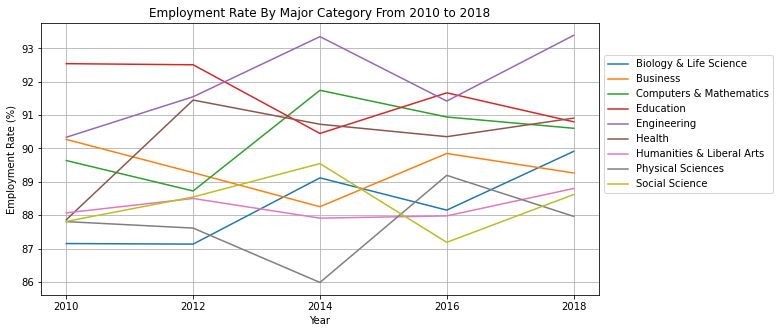

In [28]:
plt.figure(figsize=(100,4))
employment_rate_df.plot(figsize = (10, 5),
                        title = "Employment Rate By Major Category From 2010 to 2018",
                        xlabel = "Year", ylabel = "Employment Rate (%)")
plt.legend(bbox_to_anchor = (1, 0.5, 0.1, 0.4), loc = 'upper left')
plt.xticks(np.arange(0, 5, 1), ["2010", "2012", "2014", "2016", "2018"])
plt.grid()

_By looking at the line plot above, we would only keep the major categories that have an increasing trend. They are Engineer, Biology & Life Science, Computers & Mathematics, and Health. The remaing major categories that have a stable trend are Humanities & Liberal Arts and Social Science. Therefore, major categories in Engineer, Biology & Life Science, Computers & Mathematics, Health, Humanities & Liberal Arts and Social Science trend to have a stable demand of jobs _

In [19]:
# edu_wage18["WAGP"]
# len(np.unique(edu_wage18["WAGP"])),len(np.unique(edu_wage16["WAGP"])),len(np.unique(edu_wage14["WAGP"]))

In [8]:
recent_grad_stats10 = pd.read_csv("data/pums/processed/2010_recent_grad_stats_by_major.csv")
recent_grad_stats12 = pd.read_csv("data/pums/processed/2012_recent_grad_stats_by_major.csv")
recent_grad_stats14 = pd.read_csv("data/pums/processed/2014_recent_grad_stats_by_major.csv")
recent_grad_stats16 = pd.read_csv("data/pums/processed/2016_recent_grad_stats_by_major.csv")
recent_grad_stats18 = pd.read_csv("data/pums/processed/2018_recent_grad_stats_by_major.csv")

In [28]:
recent_grad_stats14.head()

,FOD1P,total,men,women,total median,women median,men median,Major,Major_Category
0,1100.0,12132,7197,4935,36443,37159,35833,GENERAL AGRICULTURE,Agriculture & Natural Resources
1,1101.0,13372,8483,4889,35000,30000,40000,AGRICULTURE PRODUCTION AND MANAGEMENT,Agriculture & Natural Resources
2,1102.0,2208,1675,533,48167,34793,50000,AGRICULTURAL ECONOMICS,Agriculture & Natural Resources
3,1103.0,24388,5936,18452,33109,34041,28691,ANIMAL SCIENCES,Agriculture & Natural Resources
4,1104.0,4644,1414,3230,43773,46624,37060,FOOD SCIENCE,Agriculture & Natural Resources


## What would bring you if you get a higher level of education?